# 주택 가격 예측

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [2]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수\n', isnull_series[isnull_series>0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 칼럼과 그 건수
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


<AxesSubplot:title={'center':'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

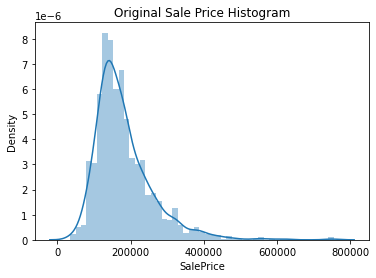

In [3]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

<AxesSubplot:title={'center':'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

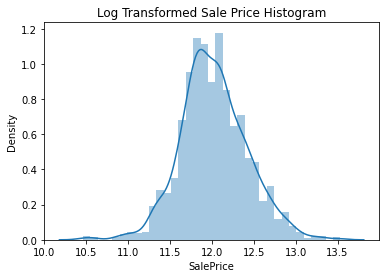

In [4]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [5]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불피요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

# 드롭하지 않은 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('\nNull 피처의 Type :\n', house_df.dtypes[null_column_count.index])


Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [6]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type: \n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type: 
 Series([], dtype: object)


In [7]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__,'로그 변환된 RMSE:',np.round(rmse,3))
    return rmse

def get_rmses(models):
    rmses=[]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso()
lasso_reg.fit(X_train,y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.1318957657915436, 0.12750846334053045, 0.17628250556471395]

In [9]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

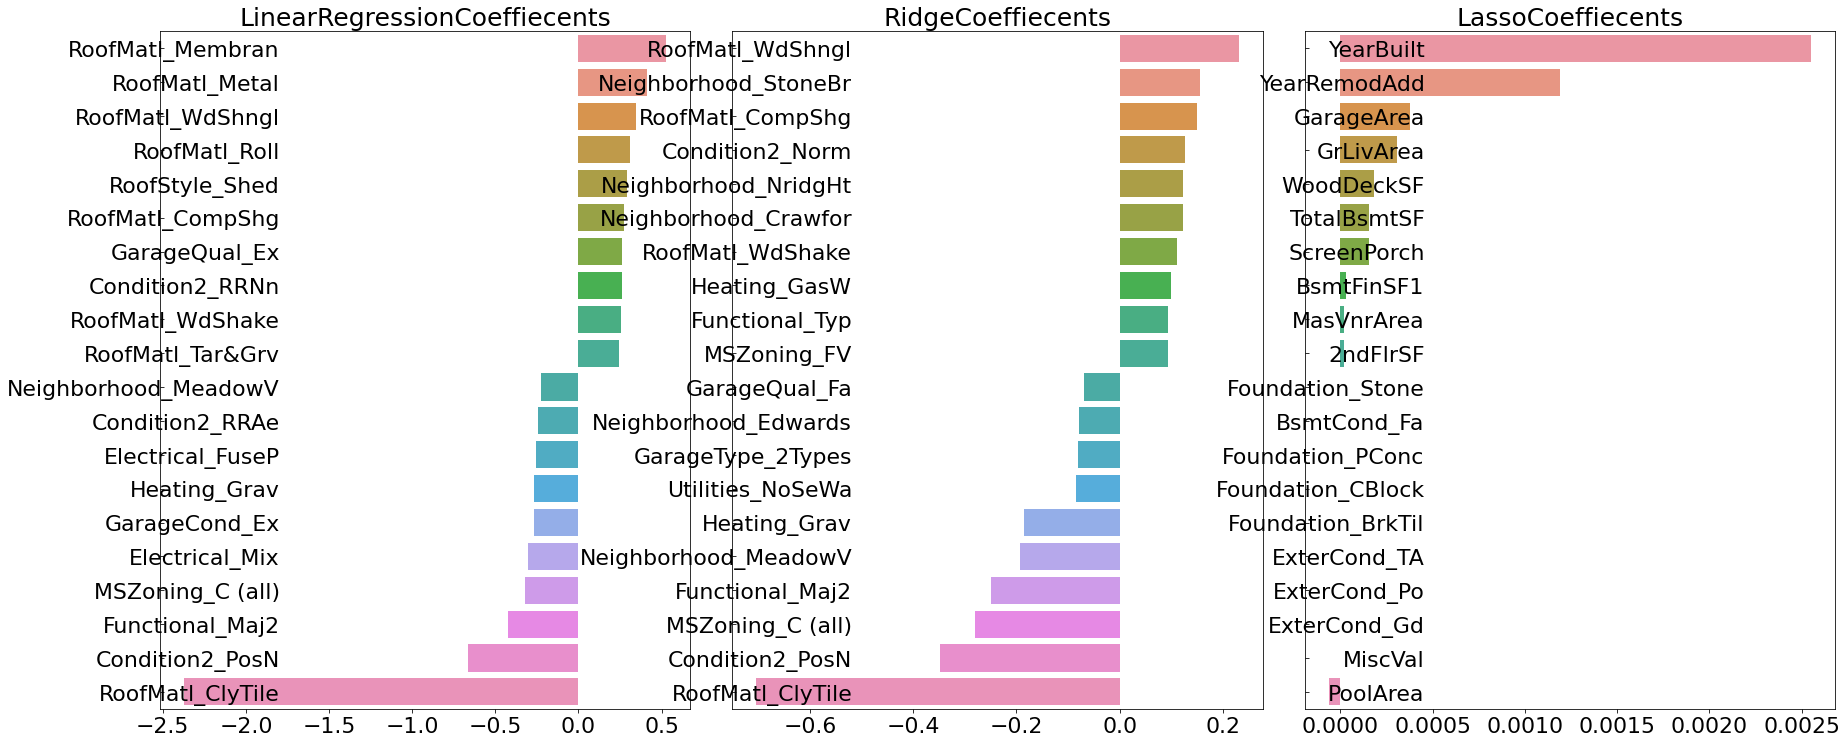

In [10]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위10개, 하위10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+'Coeffiecents',size=25)
        axs[i_num].tick_params(axis='y',direction='in',pad=-120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [11]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
        
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list,3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__,np.round(rmse_avg,3)))
        
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


In [15]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha: {2}'.format(model.__class__.__name__, np.round(rmse,4),grid_model.best_params_))
    
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha: {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha: {'alpha': 0.001}


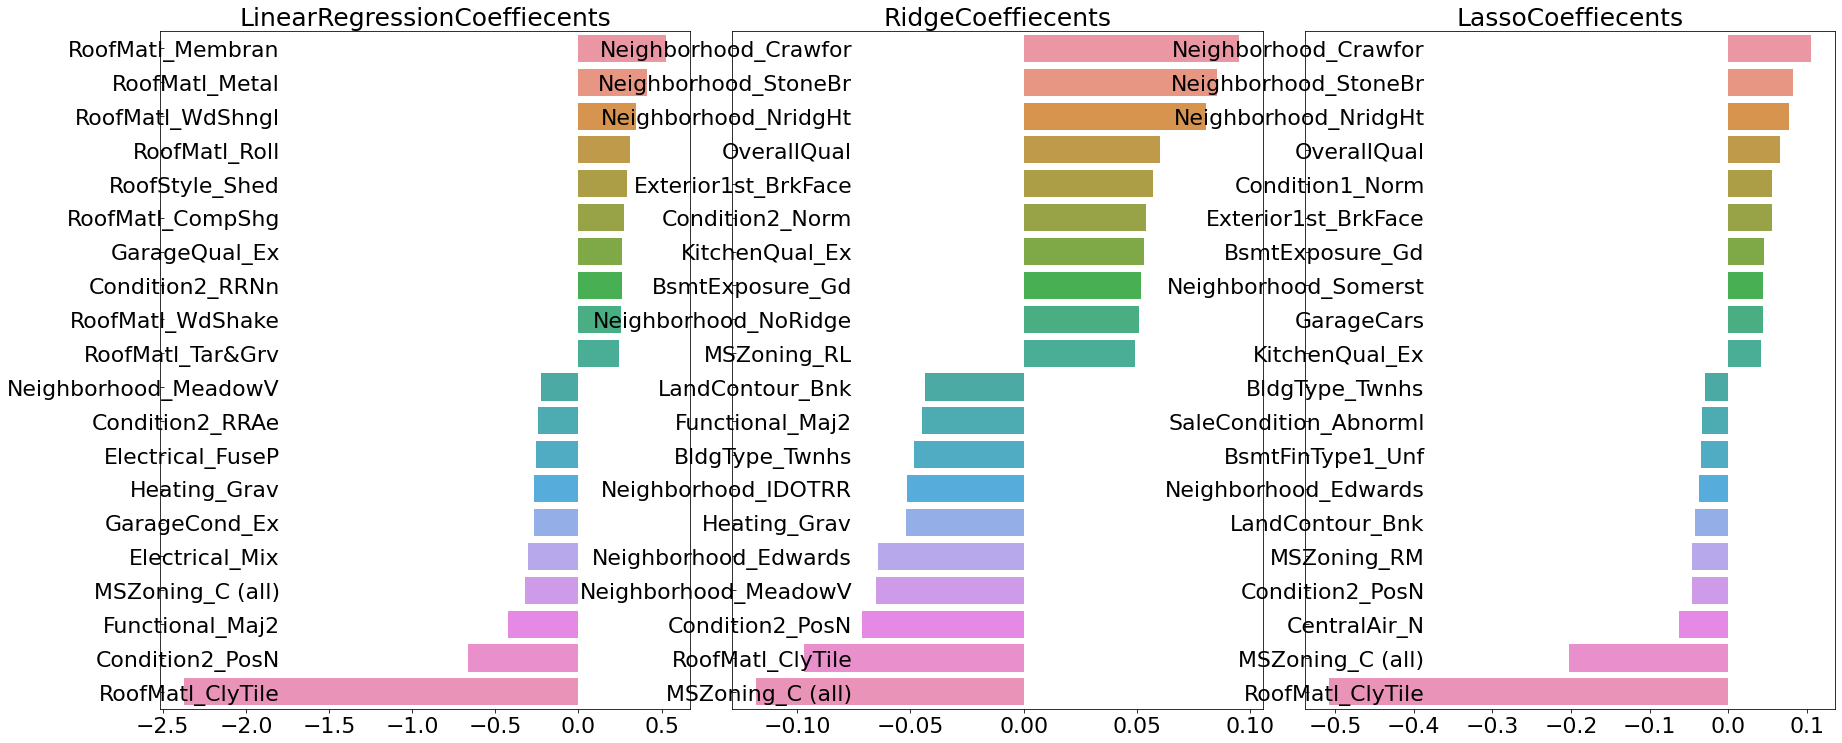

In [17]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

# 모든 모델의 RMSE 출력
models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [18]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda 로 skew()호출
skew_features = house_df[features_index].apply(lambda x: skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [19]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [20]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe= pd.get_dummies(house_df)
y_target=house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha: {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1252, 최적 alpha: {'alpha': 0.001}


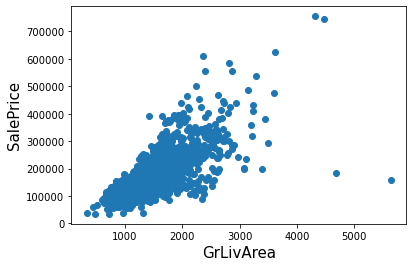

In [22]:
plt.scatter(x=house_df_org['GrLivArea'],y=house_df_org['SalePrice'])
plt.ylabel('SalePrice',fontsize=15)
plt.xlabel('GrLivArea',fontsize=15)
plt.show()

In [23]:
# GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea']>np.log1p(4000)
cond2 = house_df_ohe['SalePrice']<np.log1p(500000)
outlier_index=house_df_ohe[cond1&cond2].index

print('이상치 레코드 index:',outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:',house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:',house_df_ohe.shape)

이상치 레코드 index: [ 523 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 271)
이상치 삭제 후 house_df_ohe shape: (1458, 271)


In [24]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 alpha: {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha: {'alpha': 0.001}


In [26]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse=np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))
        
# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10007930884470519
Ridge 모델의 RMSE: 0.10345177546603272
Lasso 모델의 RMSE: 0.10024170460890039


In [28]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred=lgbm_reg.predict(X_test)

pred=0.5*xgb_pred + 0.5*lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         "LGBM": lgbm_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10170077353447762
XGBM 모델의 RMSE: 0.10738295638346222
LGBM 모델의 RMSE: 0.10382510019327311


In [31]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds값으로 KFold 생성
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__,'model 시작')
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트:', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [34]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base) 모델이 생성한 학습한/테스트용 데이터 변환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
Lasso model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
XGBRegressor model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
LGBMRegressor model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작


In [35]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse=mean_squared_error(y_test, final)
rmse=np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.0979915296518969
